In [1]:
# Basic numerical & plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    balanced_accuracy_score,
    confusion_matrix
)

# Reproducibility
np.random.seed(42)

In [2]:
# Load Breast Cancer Wisconsin (Diagnostic) dataset
data = load_breast_cancer()

X = data.data
y = data.target

feature_names = data.feature_names
target_names = data.target_names

print("Dataset loaded")
print("Features shape:", X.shape)
print("Labels shape:", y.shape)
print("Classes:", target_names)

Dataset loaded
Features shape: (569, 30)
Labels shape: (569,)
Classes: ['malignant' 'benign']


In [3]:
# Train-test split (fixed for reproducibility)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (455, 30)
Test shape: (114, 30)


In [4]:
# Standardize features
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
# Create DataFrame
df = pd.DataFrame(X_train_scaled, columns=feature_names)

# Compute correlation matrix
corr_matrix = df.corr()

In [8]:
# Upper triangle of correlation matrix
upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

# Correlation threshold
corr_threshold = 0.9

# Columns to drop
to_drop = [
    column for column in upper_triangle.columns
    if any(upper_triangle[column] > corr_threshold)
]

In [9]:
# Convert scaled arrays to DataFrame for pruning
X_train_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_df = pd.DataFrame(X_test_scaled, columns=feature_names)

# Drop correlated features
X_train_reduced = X_train_df.drop(columns=to_drop).values
X_test_reduced = X_test_df.drop(columns=to_drop).values

print("Reduced train shape:", X_train_reduced.shape)
print("Reduced test shape :", X_test_reduced.shape)


Reduced train shape: (455, 20)
Reduced test shape : (114, 20)


In [10]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)

    print(f"\n{model_name}")
    print(f"Accuracy          : {acc:.4f}")
    print(f"F1 Score          : {f1:.4f}")
    print(f"Balanced Accuracy : {bal_acc:.4f}")

    return {
        "Model": model_name,
        "Accuracy": acc,
        "F1": f1,
        "Balanced Accuracy": bal_acc
    }

In [11]:
results = []
# RBF SVM
rbf_svm = SVC(kernel="rbf", C=1.0, gamma="scale")
results.append(
    evaluate_model(
        rbf_svm,
        X_train_reduced,
        X_test_reduced,
        y_train,
        y_test,
        model_name="RBF SVM"
    )
)


RBF SVM
Accuracy          : 0.9649
F1 Score          : 0.9718
Balanced Accuracy : 0.9673


Without pruning:

In [12]:
results_full = []
# RBF SVM (no pruning)
rbf_svm_full = SVC(kernel="rbf", C=1.0, gamma="scale")
results_full.append(
    evaluate_model(
        rbf_svm_full,
        X_train_scaled,
        X_test_scaled,
        y_train,
        y_test,
        model_name="RBF SVM (Full Features)"
    )
)


RBF SVM (Full Features)
Accuracy          : 0.9825
F1 Score          : 0.9861
Balanced Accuracy : 0.9812


In [13]:
def plot_confusion(model, X_train, X_test, y_train, y_test, title, filename):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=target_names,
        yticklabels=target_names
    )

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

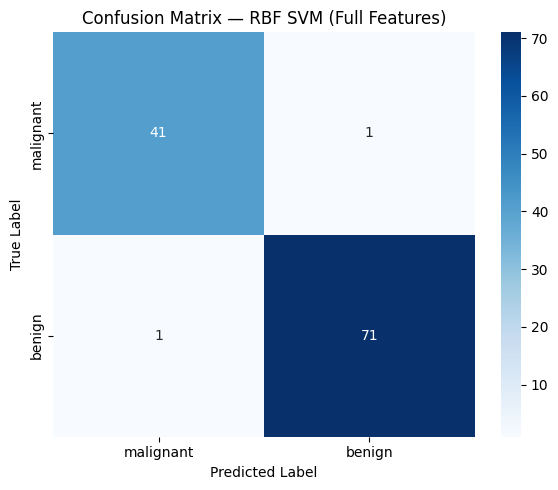

In [14]:
rbf_full = SVC(kernel="rbf", C=1.0, gamma="scale")

plot_confusion(
    model=rbf_full,
    X_train=X_train_scaled,
    X_test=X_test_scaled,
    y_train=y_train,
    y_test=y_test,
    title="Confusion Matrix — RBF SVM (Full Features)",
    filename="confusion_matrix_rbf_full.png"
)